In [1]:
import pandas as pd
import numpy as np
from itertools import product
from math import sqrt
import matplotlib.pyplot as plt
import os

file_path = r"C:\Users\brend\pitch_api\data\All Cape League Trackman.csv"
df = pd.read_csv(file_path)
df.columns = df.columns.str.strip()

C:\Users\brend\AppData\Local\Temp\ipykernel_8032\1560395906.py:9: DtypeWarning: Columns (27,168,185,186,187,188,189,190,199,234,235,236,237,238,239,240,251,252,253,254,255,256,257,261,263,264,265,325,326,327,328,329) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


In [2]:
cols = [
    "Pitcher", "PitcherId", "PitcherThrows", "Batter", "BatterId", "BatterSide",
    "PitchofPA", "PAofInning", "TaggedPitchType", "AutoPitchType", "PitchCall",
    "PlayResult", "RelSpeed", "VertBreak", "HorzBreak", "SpinRate", "KorBB", "ExitSpeed"
]
df = df[cols].dropna(subset=["Pitcher", "TaggedPitchType", "RelSpeed"])

In [3]:
df["pa_id"] = df.groupby(["Pitcher", "PAofInning"]).ngroup()

profile_means = df.groupby("TaggedPitchType")[["RelSpeed", "VertBreak", "HorzBreak"]].mean()
pitch_types = profile_means.index.tolist()

def compute_vas_raw(a_vec, b_vec, velo_weight=1.3):
    velo_diff = abs(a_vec[0] - b_vec[0]) ** velo_weight
    move_diff = sqrt((a_vec[1] - b_vec[1]) ** 2 + (a_vec[2] - b_vec[2]) ** 2)
    return velo_diff + 0.7 * move_diff

vas_lookup = {}
raw_vals = []
for a, b in product(pitch_types, repeat=2):
    if a == b:
        continue
    key = tuple(sorted([a, b]))
    if key in vas_lookup:
        continue
    raw = compute_vas_raw(profile_means.loc[a].values, profile_means.loc[b].values)
    vas_lookup[key] = raw
    raw_vals.append(raw)

minr, maxr = min(raw_vals), max(raw_vals)
for k in vas_lookup:
    vas_lookup[k] = (vas_lookup[k] - minr) / (maxr - minr)

In [4]:
df_sorted = df.sort_values(["Pitcher", "pa_id", "PitchofPA"]).reset_index(drop=True)
df_sorted["Pitch1"] = df_sorted["TaggedPitchType"]
df_sorted["Pitch2"] = df_sorted.groupby("pa_id")["TaggedPitchType"].shift(-1)
df_sorted["next_pitch_call"] = df_sorted.groupby("pa_id")["PitchCall"].shift(-1)
df_sorted["next_exit_speed"] = df_sorted.groupby("pa_id")["ExitSpeed"].shift(-1)

two_df = df_sorted.dropna(subset=["Pitch2"]).copy()

two_df["vas"] = two_df.apply(lambda r: vas_lookup.get(tuple(sorted([r["Pitch1"], r["Pitch2"]])), 0), axis=1)

swing_calls = ["FoulBallNotFieldable", "StrikeSwinging", "InPlay", "FoulBallFieldable"]
two_df["whiff"] = (two_df["next_pitch_call"] == "StrikeSwinging").astype(int)
two_df["swing"] = two_df["next_pitch_call"].isin(swing_calls).astype(int)

two_df["exit_v_allowed"] = two_df["next_exit_speed"].where(two_df["next_pitch_call"] == "InPlay")

In [5]:
agg_global = two_df.groupby(["Pitch1", "Pitch2"]).agg(
    n=("whiff", "count"),
    vas=("vas", "mean"),
    whiff_sum=("whiff", "sum"),
    swing_sum=("swing", "sum"),
    exit_v_allowed=("exit_v_allowed", "mean"),
    n_pa=("pa_id", "nunique")
).reset_index()

prior_success = 0.25
prior_total = 4
agg_global["whiff_rate"] = (agg_global["whiff_sum"] + prior_success) / (agg_global["swing_sum"] + prior_total)

total_pairs = agg_global["n"].sum()
agg_global["usage"] = agg_global["n"] / total_pairs

alpha, beta, gamma = 0.45, 0.40, 0.15
agg_global["success"] = (1 - (agg_global["exit_v_allowed"] / agg_global["exit_v_allowed"].max()).fillna(0)) * 0.6 + agg_global["whiff_rate"] * 0.4

agg_global["SSI"] = alpha * agg_global["vas"] + beta * agg_global["success"] + gamma * (1 - agg_global["usage"])
agg_global["Opportunity"] = (1 - agg_global["usage"]) * agg_global["vas"] * (1 + (1 - agg_global["success"]))
agg_global["Opportunity_scaled"] = agg_global["Opportunity"] / agg_global["Opportunity"].max()

In [6]:
def analyze_pitcher(player_name, export=True, plot=True):
    player_df = two_df[two_df["Pitcher"].str.lower() == player_name.lower()]
    if player_df.empty:
        print(f"No data found for pitcher: {player_name}")
        return

    agg_p = player_df.groupby(["Pitch1", "Pitch2"]).agg(
        n=("whiff", "count"),
        vas=("vas", "mean"),
        whiff_sum=("whiff", "sum"),
        swing_sum=("swing", "sum"),
        exit_v_allowed=("exit_v_allowed", "mean"),
        n_pa=("pa_id", "nunique")
    ).reset_index()

    agg_p = agg_p[agg_p["n"] >= 5].copy()

    agg_p = agg_p.merge(agg_global[["Pitch1", "Pitch2", "usage"]], on=["Pitch1", "Pitch2"], how="left")
    agg_p["usage"] = agg_p["usage"].fillna(0)

    prior_success = 0.25
    prior_total = 4
    agg_p["whiff_rate"] = (agg_p["whiff_sum"] + prior_success) / (agg_p["swing_sum"] + prior_total)

    global_max_exit = agg_global["exit_v_allowed"].max()
    agg_p["success"] = np.where(
        agg_p["exit_v_allowed"].isna(),
        agg_p["whiff_rate"],
        (1 - (agg_p["exit_v_allowed"] / global_max_exit)) * 0.7 + agg_p["whiff_rate"] * 0.3
    )

    agg_p["SSI"] = alpha * agg_p["vas"] + beta * agg_p["success"] + gamma * (1 - agg_p["usage"])
    agg_p["Opportunity"] = (1 - agg_p["usage"]) * agg_p["vas"] * (1 + (1 - agg_p["success"]))
    agg_p["Opportunity_scaled"] = agg_p["Opportunity"] / (agg_p["Opportunity"].max() if agg_p["Opportunity"].max() > 0 else 1)

    agg_p = agg_p[["Pitch1", "Pitch2", "vas", "whiff_rate", "exit_v_allowed", "usage", "success", "SSI", "Opportunity", "Opportunity_scaled"]]

    print(f"\n=== {player_name.upper()} — Top Pitch Pairings by SSI ===")
    print(agg_p.sort_values("SSI", ascending=False).head(10))

    print(f"\n=== {player_name.upper()} — Top Pitch Pairings by Opportunity ===")
    print(agg_p.sort_values("Opportunity", ascending=False).head(10))

    if plot:
        plt.figure(figsize=(8,6))
        plt.scatter(agg_p["usage"], agg_p["SSI"], s=100*(1+agg_p["usage"]))

        for _, row in agg_p.iterrows():
            plt.text(row["usage"]+0.001, row["SSI"]+0.001, f"{row['Pitch1']}-{row['Pitch2']}", fontsize=8)

        plt.xlabel("Usage (Frequency of Sequence)")
        plt.ylabel("SSI (Sequence Strength Index)")
        plt.title(f"{player_name} — Usage vs SSI")
        plt.grid(True)
        plt.xlim(0, 0.12)
        plt.ylim(0, 1)

        plt.show()

    if export:
        os.makedirs(r"C:\Users\brend\pitch_api\outputs", exist_ok=True)
        out_path = fr"C:\Users\brend\pitch_api\outputs\{player_name.replace(' ', '_')}_sequence_analysis.csv"
        agg_p.to_csv(out_path, index=False)
        print(f"Saved pitcher summary → {out_path}")


=== ECHEMAN, KADEN — Top Pitch Pairings by SSI ===
       Pitch1     Pitch2       vas  whiff_rate  exit_v_allowed     usage  \
5   Four-Seam  Curveball  0.922110    0.464286             NaN  0.018603   
2   Curveball  Four-Seam  0.922110    0.138889             NaN  0.018946   
1   Curveball     Cutter  0.495973    0.160714       60.228760  0.004087   
7   Four-Seam     Slider  0.633975    0.041667       76.384820  0.039669   
4      Cutter  Four-Seam  0.326484    0.187500       93.562360  0.014401   
8      Slider  Curveball  0.211561    0.156250             NaN  0.010772   
10     Slider   Splitter  0.119190    0.062500             NaN  0.001585   
3      Cutter     Cutter  0.000000    0.132353       81.542706  0.013751   
6   Four-Seam  Four-Seam  0.000000    0.292857       85.853129  0.100405   
9      Slider     Slider  0.000000    0.204545       90.703160  0.049715   

     success       SSI  Opportunity  Opportunity_scaled  
5   0.464286  0.747873     1.389754            0.8254

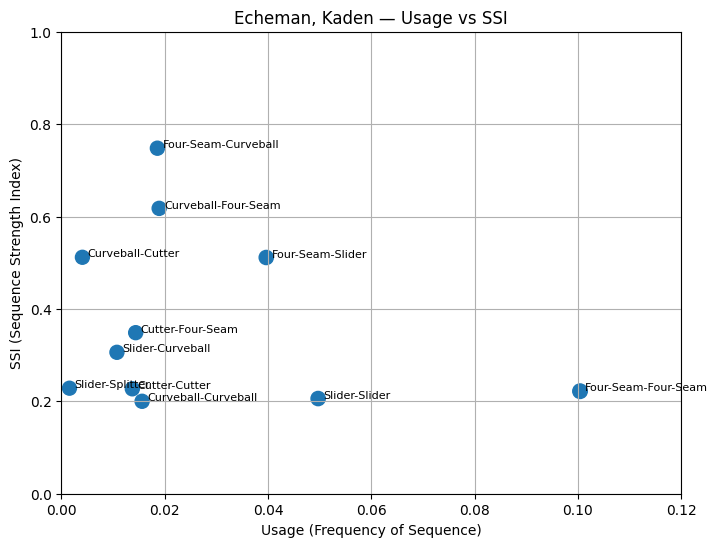

Saved pitcher summary → C:\Users\brend\pitch_api\outputs\Echeman,_Kaden_sequence_analysis.csv


In [7]:
analyze_pitcher("Echeman, Kaden")